# Prepare notebook

In [1]:
!pip install gdown -q

In [2]:
!gdown 18KIvMBWD031oDvg0DVebI06SMwKuTp4l -O sh3_sc6_y32_x32_imgs.npz

Downloading...
From (original): https://drive.google.com/uc?id=18KIvMBWD031oDvg0DVebI06SMwKuTp4l
From (redirected): https://drive.google.com/uc?id=18KIvMBWD031oDvg0DVebI06SMwKuTp4l&confirm=t&uuid=9ccc6f95-b93a-4298-b5c7-1f0e9cfe2a1b
To: /content/sh3_sc6_y32_x32_imgs.npz
100% 75.5M/75.5M [00:00<00:00, 119MB/s]


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


### Constants

In [5]:
DATA_PATH = './sh3_sc6_y32_x32_imgs.npz'
TRAIN_RATIO = 0.9

LATENT_DIM = 256
Z_DIM = 10

BETA_1 = 0.9
BETA_2 = 0.99
LEARNING_RATE = 1e-4

BATCH_SIZE = 128
TRAIN_EPOCHS = 10

W_KL = 1
W_REC = 1

## Data

In [6]:
class DspritesDataset(Dataset):

    def __init__(self, npz_path, transform=None):
        data = np.load(npz_path, allow_pickle=True, encoding='latin1')
        self.transform = transform
        self.images = data['imgs']

        if self.transform is None:
          self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = self.transform(image)
        return image


In [7]:
raw_dataset = DspritesDataset(DATA_PATH)
print(len(raw_dataset))

18432


In [8]:
train_size = int(TRAIN_RATIO * len(raw_dataset))
test_size = len(raw_dataset) - train_size
lengths = [train_size, test_size]

train_dataset, test_dataset = random_split(raw_dataset, lengths)

In [9]:
print(f'Train size: {len(train_dataset)}')
print(f'Test size: {len(test_dataset)}')

Train size: 16588
Test size: 1844


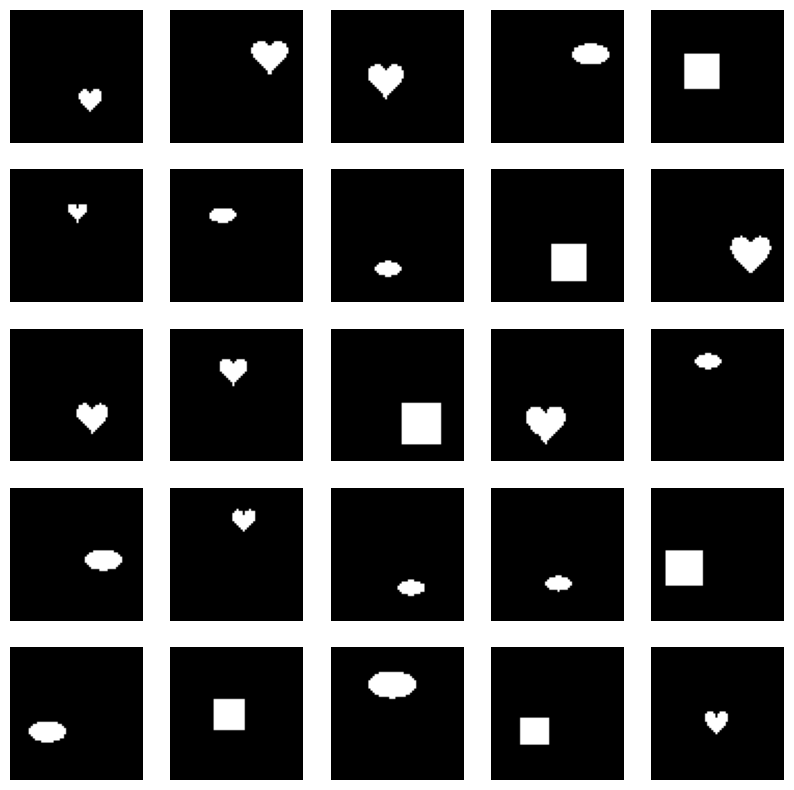

In [12]:
import random

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    idx = random.randint(0, len(train_dataset)-1)
    plt.imshow(train_dataset[idx].squeeze(), cmap='gray')
    plt.axis('off')

## VariationalAutoEncoder Model

In [13]:
class VAE(nn.Module):
    def __init__(self, latent_dim, z_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=4, stride=1),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(latent_dim, z_dim)
        self.fc_sigma = nn.Linear(latent_dim, z_dim)
        self.fc_decoder = nn.Linear(z_dim, latent_dim)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=64, kernel_size=4),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=4, stride=2, padding=1),
        )

    def reparameterize(self, mu, sigma):
        std = torch.exp(sigma / 2.)
        eps = torch.randn_like(mu).to(mu.get_device())
        return mu + std * eps

    def encode(self, x):
        h = self.encoder(x)
        h = h.view(-1, 256)
        mu = self.fc_mu(h)
        sigma = self.fc_sigma(h)
        return h, mu, sigma

    def decode(self, z):
        h = self.fc_decoder(z)
        h = h.view(-1, 256, 1, 1)
        x = self.decoder(h)
        return x

    def forward(self, x):
        _, mu, sigma = self.encode(x)
        z = self.reparameterize(mu, sigma)
        x = self.decode(z)
        return x, mu, sigma


## Train utils

In [14]:
def kl_divergence(mu, sigma):
    return -0.5 * torch.mean(1 + sigma - mu.pow(2) - sigma.exp())

In [15]:
def reconstruction_loss(x, x_hat):
    return F.binary_cross_entropy_with_logits(x_hat, x, reduction='mean')

In [16]:
def vae_loss(x, x_hat, mu, sigma):
    return W_REC * reconstruction_loss(x, x_hat) + W_KL * kl_divergence(mu, sigma)

In [17]:
@torch.no_grad()
def model_eval(model, loader, criterion):
  """Returns total_loss, reconstruction loss, kld_loss"""
  total_loss = 0.0
  rec_loss = 0.0
  kl_loss = 0.0
  total_samples = 0

  model.eval()
  itr = tqdm(loader, total=len(loader), leave=False)

  for batch in itr:
      total_samples += len(batch)
      batch = batch.to(DEVICE)

      _x, _mu, _sigma = model(batch)

      loss = criterion(batch, _x, _mu, _sigma)

      total_loss += loss.item()
      kl_loss += kl_divergence(_mu, _sigma).item()
      rec_loss += reconstruction_loss(batch, _x).item()


      itr.set_description("(Eval)")
      itr.set_postfix(
          total_loss=round(total_loss/total_samples, 4),
          kd_div=round(kl_loss/total_samples, 4),
          rec_loss=round(rec_loss/total_loss, 4),
      )

  total_loss = total_loss / total_samples
  rec_loss = rec_loss / total_samples
  kl_loss = kl_loss / total_samples

  return total_loss, rec_loss, kl_loss


In [24]:
def train_model(
        model,
        batch_size,
        epochs,
        criterion,
        train_set,
        test_set,
        lr=2e-5,
):

  train_total_losses = []
  test_total_losses = []

  train_kl_losses = []
  test_kl_losses = []

  train_rec_losses = []
  test_rec_losses = []

  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
  test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False)

  optimizer = optim.Adam(model.parameters(), lr=lr, betas=(BETA_1, BETA_2))

  itr = tqdm(train_loader, total=len(train_loader), leave=False)

  for epoch in range(epochs):
      model.train()
      epoch_total_loss = 0
      epoch_kl_loss = 0
      epoch_rec_loss = 0
      epoch_samples = 0
      for batch in itr:
          epoch_samples += len(batch)
          batch = batch.to(DEVICE)

          _x, _mu, _sigma = model(batch)
          loss = criterion(batch, _x, _mu, _sigma)

          epoch_total_loss += loss.item()

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          epoch_kl_loss += kl_divergence(_mu, _sigma).item()
          epoch_rec_loss += reconstruction_loss(batch, _x).item()

          itr.set_description(f"(Training) Epoch [{epoch + 1}/{epochs}]")
          itr.set_postfix(
            loss=round(loss.item(), 5),
          )

      train_total_losses.append(epoch_total_loss/epoch_samples)
      train_kl_losses.append(epoch_kl_loss/epoch_samples)
      train_rec_losses.append(epoch_rec_loss/epoch_samples)


      model.eval()
      test_total_loss, test_rec_loss, test_kl_loss = model_eval(
          model=model,
          loader=test_loader,
          criterion=criterion,
      )
      test_total_losses.append(test_total_loss)
      test_kl_losses.append(test_kl_loss)
      test_rec_losses.append(test_rec_loss)


  history = {
    "Train_Total_Loss": train_total_losses,
    "Train_Rec_Loss": train_rec_losses,
    "Train_KL_Loss": train_kl_losses,

    "Test_Total_Loss": test_total_losses,
    "Test_Rec_Loss": test_rec_losses,
    "Test_KL_Loss": test_kl_losses,
  }
  return history

In [31]:
def plot_reconstructions(model, dataset, n=5):
    test_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
    model.eval()
    with torch.no_grad():
        batch = iter(test_dataloader).__next__().to(DEVICE)
        x_hat, *_ = model(batch)

    plt.figure(figsize=(4*n, 6))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(batch[i][0].cpu(), cmap='gray')
        plt.title("Original")
        plt.axis('off')
        plt.subplot(2, n, i+1+n)
        plt.imshow(x_hat[i][0].cpu(), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')
    plt.show()

In [37]:
def trend_plot_helper(pobj):
    plt.figure(figsize=(8*len(pobj), 6))
    for idx, (titler, plots) in enumerate(pobj.items(), start=1):
        plt.subplot(1, len(pobj), idx)
        for label, trend in plots:
            plt.plot(range(1, len(trend)+1), trend, label=label)
        yt, xt = titler.split(' - ')
        plt.xlabel(xt)
        plt.ylabel(yt)
        plt.legend()

## Ordinary VAE

In [20]:
model_ovae = VAE(LATENT_DIM, Z_DIM).to(DEVICE)

In [25]:
history = train_model(
        model=model_ovae,
        batch_size=BATCH_SIZE,
        epochs=TRAIN_EPOCHS,
        criterion=vae_loss,
        train_set=train_dataset,
        test_set=test_dataset,
        lr=LEARNING_RATE,
)

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

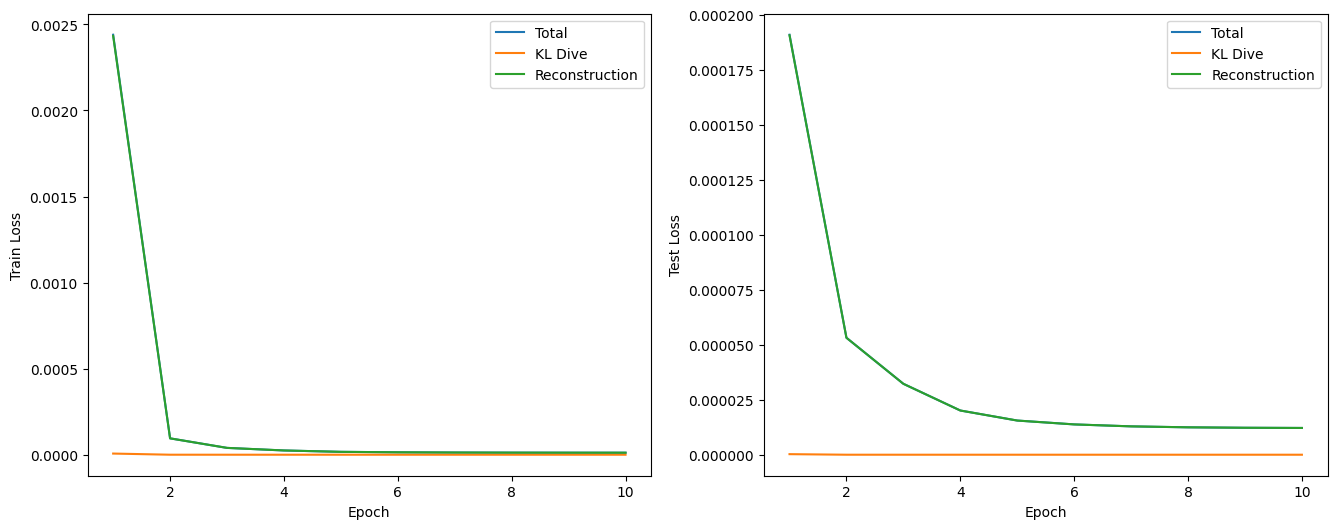

In [38]:
trend_plot_helper(
    {
        "Train Loss - Epoch": [
            ("Total", history["Train_Total_Loss"]),
            ("KL Dive", history["Train_KL_Loss"]),
            ("Reconstruction", history["Train_Rec_Loss"]),
        ],
        "Test Loss - Epoch": [
            ("Total", history["Test_Total_Loss"]),
            ("KL Dive", history["Test_KL_Loss"]),
            ("Reconstruction", history["Test_Rec_Loss"]),
        ]
    }
)

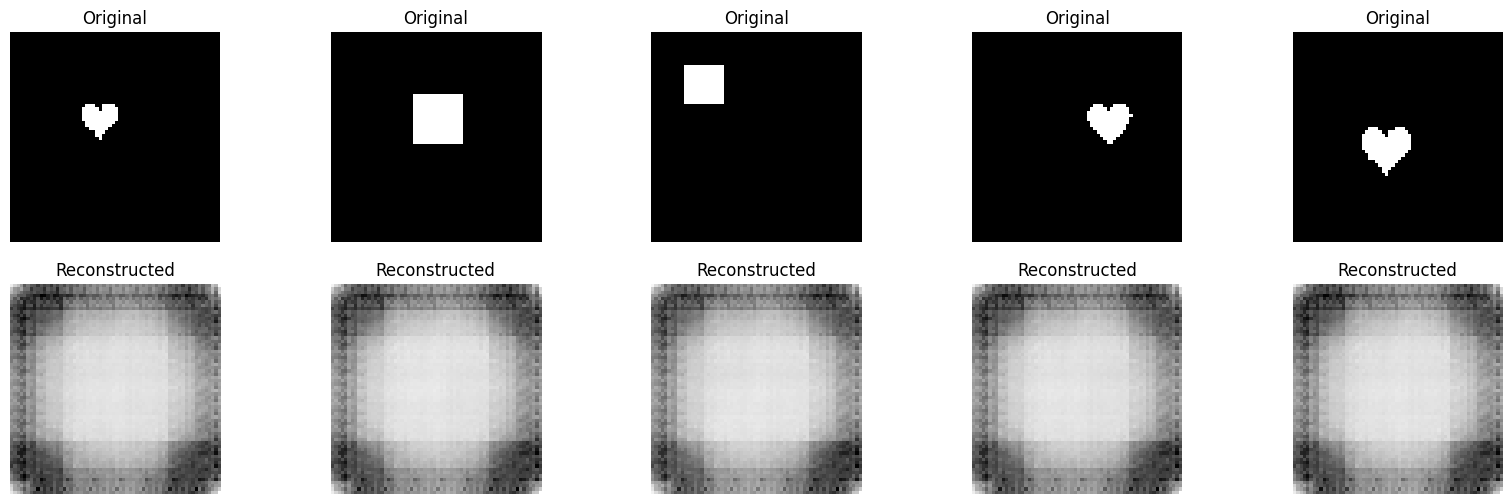

In [32]:
plot_reconstructions(model_ovae, test_dataset)